1. Collect and prepare data
2. Develop a hypothesis for a strategy
3. Train the ML model
4. Backtest

## 1. Download S&P500 stock data

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings

warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-12-23'
start_date = '2015-12-23'

df = yf.download(tickers = symbols_list, start = start_date, end = end_date, auto_adjust=False, actions=False).stack()

[*********************100%***********************]  503 of 503 completed


In [2]:
df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2015-12-23 A        38.842495   41.770000   41.860001   41.389999   41.619999   
           AAPL     24.598934   27.152500   27.212500   26.799999   26.817499   
           ABBV     40.002373   58.580002   58.610001   57.610001   57.880001   
           ABT      38.064724   45.099998   45.180000   44.630001   44.730000   
           ACGL     23.463333   23.463333   23.546667   23.340000   23.450001   
...                       ...         ...         ...         ...         ...   
2024-12-20 XYL     117.139999  117.139999  118.120003  115.900002  116.070000   
           YUM     132.360001  132.360001  133.380005  130.139999  130.250000   
           ZBH     107.120003  107.120003  107.779999  105.339996  105.339996   
           ZBRA    393.040009  393.040009  395.029999  382.850006  383.350006   
           ZTS     164.839996  164.839996  166.389999  163.529999  163.759995   

Price                   Volume  
Date       Ticker               
2015-12-23 A         1510700.0  
           AAPL    130629600.0  
           ABBV      6634400.0  
           ABT       4353000.0  
           ACGL       644100.0  
...                        ...  
2024-12-20 XYL       2799600.0  
           YUM       3212900.0  
           ZBH       3969100.0  
           ZBRA       826400.0  
           ZTS       6220100.0  

[1112409 rows x 6 columns]

In [3]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

In [4]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-12-23 A        38.842495   41.770000   41.860001   41.389999   41.619999   
           AAPL     24.598934   27.152500   27.212500   26.799999   26.817499   
           ABBV     40.002373   58.580002   58.610001   57.610001   57.880001   
           ABT      38.064724   45.099998   45.180000   44.630001   44.730000   
           ACGL     23.463333   23.463333   23.546667   23.340000   23.450001   
...                       ...         ...         ...         ...         ...   
2024-12-20 XYL     117.139999  117.139999  118.120003  115.900002  116.070000   
           YUM     132.360001  132.360001  133.380005  130.139999  130.250000   
           ZBH     107.120003  107.120003  107.779999  105.339996  105.339996   
           ZBRA    393.040009  393.040009  395.029999  382.850006  383.350006   
           ZTS     164.839996  164.839996  166.389999  163.529999  163.759995   

Price                   volume  
date       ticker               
2015-12-23 A         1510700.0  
           AAPL    130629600.0  
           ABBV      6634400.0  
           ABT       4353000.0  
           ACGL       644100.0  
...                        ...  
2024-12-20 XYL       2799600.0  
           YUM       3212900.0  
           ZBH       3969100.0  
           ZBRA       826400.0  
           ZTS       6220100.0  

[1112409 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

Garman-Klass Volatility = (ln(High) - ln(Low))^2/2 - (2ln(2) - 1)(ln(Adj Close)- In(Open))^2

 Refer- 
 - </h> https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/RSI
 - </h> https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/bollinger-bands
 - </h> https://www.investopedia.com/terms/a/atr.asp
 - </h> https://www.investopedia.com/terms/m/macd.asp
 
 

In [6]:
df['garman_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low']))**2) / 2
    - (2 * (np.log(2)) - 1) * ((np.log(df['adj close']) - np.log(df['open']))**2)
)

# group by with the ticker level, which is level 1
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, 
                                                                                length = 20))


df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,0])

df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,1])

df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,2])


# ATR requires 3 columns for its calculation which is why we cant use transform function

def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                            low = stock_data['low'], 
                            close = stock_data['close'], length = 14)
    return atr.sub(atr.mean()).div(atr.std()) #normalization

df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close = close, length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std()) #normalization

df['macd']= df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)


df['dollar_volume'] = df['adj close']*df['volume']/1e6


In [7]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-12-23 A        38.842495   41.770000   41.860001   41.389999   41.619999   
           AAPL     24.598934   27.152500   27.212500   26.799999   26.817499   
           ABBV     40.002373   58.580002   58.610001   57.610001   57.880001   
           ABT      38.064724   45.099998   45.180000   44.630001   44.730000   
           ACGL     23.463333   23.463333   23.546667   23.340000   23.450001   
...                       ...         ...         ...         ...         ...   
2024-12-20 XYL     117.139999  117.139999  118.120003  115.900002  116.070000   
           YUM     132.360001  132.360001  133.380005  130.139999  130.250000   
           ZBH     107.120003  107.120003  107.779999  105.339996  105.339996   
           ZBRA    393.040009  393.040009  395.029999  382.850006  383.350006   
           ZTS     164.839996  164.839996  166.389999  163.529999  163.759995   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-12-23 A         1510700.0         -0.001779        NaN       NaN   
           AAPL    130629600.0         -0.002764        NaN       NaN   
           ABBV      6634400.0         -0.052574        NaN       NaN   
           ABT       4353000.0         -0.009983        NaN       NaN   
           ACGL       644100.0          0.000039        NaN       NaN   
...                        ...               ...        ...       ...   
2024-12-20 XYL       2799600.0          0.000147  35.482069  4.763016   
           YUM       3212900.0          0.000203  43.398034  4.886420   
           ZBH       3969100.0          0.000154  47.178406  4.662801   
           ZBRA       826400.0          0.000250  50.032642  5.960888   
           ZTS       6220100.0          0.000134  34.256644  5.117464   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-12-23 A            NaN       NaN       NaN       NaN      58.679357  
           AAPL         NaN       NaN       NaN       NaN    3213.348932  
           ABBV         NaN       NaN       NaN       NaN     265.391742  
           ABT          NaN       NaN       NaN       NaN     165.695743  
           ACGL         NaN       NaN       NaN       NaN      15.112733  
...                     ...       ...       ...       ...            ...  
2024-12-20 XYL     4.828519  4.894022  1.017049 -1.585883     327.945142  
           YUM     4.924176  4.961933  0.782140 -0.680250     425.259446  
           ZBH     4.698975  4.735149 -0.358095 -0.314974     425.170003  
           ZBRA    5.999766  6.038643  0.316627 -0.079295     324.808263  
           ZTS     5.168648  5.219832  0.711959 -1.437148    1025.321261  

[1112409 rows x 14 columns]

## 3. Aggregate the data to monthly level and filter top 150 most liquid stocks

Conversion to month end frequencies reduces training time and eases experimentation with features and strategies

In [17]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open','high'
                                                          ,'low', 'close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                  df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1).dropna()

#average dollar vol for the month concatenated with other indicators that will be essential for training 

In [13]:
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-02-29 A           91.453390   34.827255         -0.002202  47.406258   
           AAPL      3530.776360   22.018019         -0.003363  47.529955   
           ABBV       344.416263   37.683064         -0.059527  47.493725   
           ABT        241.055201   32.903183         -0.011940  45.672475   
           ACGL        31.542992   22.646667          0.000102  49.220543   
...                          ...         ...               ...        ...   
2024-12-31 XYL        197.677597  117.139999          0.000147  35.482069   
           YUM        230.557354  132.360001          0.000203  43.398034   
           ZBH        178.744687  107.120003          0.000154  47.178406   
           ZBRA       136.279954  393.040009          0.000250  50.032642   
           ZTS        457.829385  164.839996          0.000134  34.256644   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-02-29 A       3.517574  3.566382  3.615190 -1.047259 -0.285633  
           AAPL    3.101585  3.126050  3.150516 -1.108589 -0.375750  
           ABBV    3.603656  3.651647  3.699638 -0.599278 -0.303951  
           ABT     3.464594  3.508165  3.551736 -0.860562 -0.469710  
           ACGL    3.135094  3.162067  3.189040 -0.727573 -0.198320  
...                     ...       ...       ...       ...       ...  
2024-12-31 XYL     4.763016  4.828519  4.894022  1.017049 -1.585883  
           YUM     4.886420  4.924176  4.961933  0.782140 -0.680250  
           ZBH     4.662801  4.698975  4.735149 -0.358095 -0.314974  
           ZBRA    5.960888  5.999766  6.038643  0.316627 -0.079295  
           ZTS     5.117464  5.168648  5.219832  0.711959 -1.437148  

[52575 rows x 9 columns]

- Calculate 5 year rolling(moving) average of dollar volume for each stock before filtering

In [18]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending = False)) #ranking stocks by dollar volume

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume','dollar_vol_rank'], axis = 1)

In [19]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-01-31 AAPL     28.095901         -0.002159  67.547609  3.327728   
           ABBV     43.780567         -0.038072  49.245577  3.779777   
           ABT      36.375008         -0.004523  66.811003  3.557928   
           ACN     100.605453         -0.005932  41.080151  4.622141   
           ADBE    113.379997          0.000042  65.319522  4.650383   
...                       ...               ...        ...       ...   
2024-12-31 WDAY    273.040009          0.000982  55.922250  5.528670   
           WFC      70.339996          0.000419  50.369637  4.233215   
           WMT      92.239998          0.000235  58.709267  4.510283   
           XOM     105.870003          0.000070  26.645452  4.655836   
           ZTS     164.839996          0.000134  34.256644  5.117464   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-01-31 AAPL    3.356231  3.384733 -1.276017 -0.136376  
           ABBV    3.810983  3.842188 -1.286221 -0.324494  
           ABT     3.591215  3.624503 -1.249366  0.195577  
           ACN     4.637113  4.652086 -1.127978 -0.414367  
           ADBE    4.706909  4.763434 -1.394258  0.105606  
...                     ...       ...       ...       ...  
2024-12-31 WDAY    5.592775  5.656881  1.783450  0.867649  
           WFC     4.304981  4.376746  2.098403 -0.303192  
           WMT     4.546060  4.581837  2.880032  2.942254  
           XOM     4.738812  4.821788  0.333464 -2.929455  
           ZTS     5.168648  5.219832  0.711959 -1.437148  

[14304 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features

- To capture time series dynamics that reflect, for example, momentum patterns for each stock, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods identified by lags.

In [20]:
def calculate_returns(df):

    outlier_cutoff = 0.005 # all values above the outlier threshold will be assigned the threshold for that percentile

    lags = [1,2,3,6,9,12] #number of months

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                upper = x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df

data = data.groupby(level=1, group_keys = False).apply(calculate_returns).dropna()

In [21]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-01-31 AAPL     39.388092         -0.001208  40.100745  3.695993   
           ABBV     83.089935         -0.042428  62.305751  4.236627   
           ABT      55.294994         -0.005933  69.274904  3.936873   
           ACN     144.842712         -0.003841  63.135443  4.952747   
           ADBE    199.759995          0.000156  65.801036  5.203949   
...                       ...               ...        ...       ...   
2024-12-31 VZ       39.930000          0.000069  35.098247  3.704012   
           WDAY    273.040009          0.000982  55.922250  5.528670   
           WFC      70.339996          0.000419  50.369637  4.233215   
           WMT      92.239998          0.000235  58.709267  4.510283   
           XOM     105.870003          0.000070  26.645452  4.655836   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-01-31 AAPL    3.736405  3.776816 -1.053510 -0.418107  -0.010636   
           ABBV    4.368567  4.500507  1.285882  1.804733   0.168700   
           ABT     3.995678  4.054483 -0.753387  0.956537   0.094397   
           ACN     4.976202  4.999656 -1.090298  0.271669   0.049709   
           ADBE    5.268046  5.332143 -1.020729  0.441801   0.139922   
...                     ...       ...       ...       ...        ...   
2024-12-31 VZ      3.770088  3.836164 -0.448452 -1.320173  -0.099459   
           WDAY    5.592775  5.656881  1.783450  0.867649   0.092204   
           WFC     4.304981  4.376746  2.098403 -0.303192  -0.076539   
           WMT     4.546060  4.581837  2.880032  2.942254  -0.000601   
           XOM     4.738812  4.821788  0.333464 -2.929455  -0.102492   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-01-31 AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553  
           ABBV     0.079892   0.077893   0.081233   0.063580    0.054846  
           ABT      0.052610   0.048209   0.041483   0.040973    0.035516  
           ACN      0.041987   0.041220   0.039210   0.032852    0.030836  
           ADBE     0.049184   0.044779   0.053053   0.045588    0.048329  
...                      ...        ...        ...        ...         ...  
2024-12-31 VZ      -0.026460  -0.033442  -0.000093  -0.000200    0.010217  
           WDAY     0.080549   0.037614   0.033885   0.000118   -0.000916  
           WFC      0.043902   0.077892   0.030896   0.023912    0.032442  
           WMT      0.062101   0.046115   0.053765   0.049606    0.049043  
           XOM     -0.047857  -0.033377  -0.012545  -0.008556    0.006907  

[12055 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas

- We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression.
- The five Fama-French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.
- We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.
- </h> https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [33]:
factor_data = web.DataReader('F-F_Research_Data_5_factors_2x3',
                             'famafrench',
                              start= '2010')[0].drop('RF', axis = 1) # excluding the risk free return column
                                                                       # as it is out of scope for this project

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

In [34]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAPL    0.0557 -0.0317 -0.0128 -0.0075 -0.0091  -0.010636
           ABBV    0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.168700
           ABT     0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.094397
           ACN     0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.049709
           ADBE    0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.139922
...                   ...     ...     ...     ...     ...        ...
2024-10-31 VZ     -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.047257
           WDAY   -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.043206
           WFC    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.149230
           WMT    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.014861
           XOM    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.003754

[11772 rows x 6 columns]

- Filter out stocks with less than 10 months of data

In [42]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >=10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]


In [43]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAPL    0.0557 -0.0317 -0.0128 -0.0075 -0.0091  -0.010636
           ABBV    0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.168700
           ABT     0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.094397
           ACN     0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.049709
           ADBE    0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.139922
...                   ...     ...     ...     ...     ...        ...
2024-10-31 VZ     -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.047257
           WDAY   -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.043206
           WFC    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.149230
           WMT    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.014861
           XOM    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.003754

[11740 rows x 6 columns]

- Calculate Rolling Factor Betas

In [46]:
betas = (factor_data.groupby(level=1,
                       group_keys= False)
     .apply(lambda x: RollingOLS(endog = x['return_1m'],
                                exog = sm.add_constant(x.drop('return_1m',axis = 1)),
                                window = min(24, x.shape[0]),
                                min_nobs = len(x.columns)+1)
     .fit(params_only = True)
     .params
     .drop('const', axis = 1)))

In [47]:
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-01-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-10-31 VZ      0.734416 -0.721646  0.401563  0.240287  0.081432
           WDAY    1.141140 -0.823419 -0.098117 -1.510394 -0.116041
           WFC     0.938968 -0.274123  1.298548 -1.246691 -0.662804
           WMT     0.650254 -0.021231 -0.191270  1.048214  0.088268
           XOM     0.366522 -0.109620  0.369991  0.571946  0.339940

[11740 rows x 5 columns]

In [48]:
betas.groupby('ticker').shift()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-01-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-10-31 VZ      0.552161 -0.779987  0.380001 -0.048089 -0.091636
           WDAY    1.092390 -0.892179 -0.079425 -1.748179  0.018144
           WFC     1.108943 -0.146507  1.284971 -0.756497 -0.749953
           WMT     0.695970  0.009132 -0.193099  1.168087  0.078276
           XOM     0.624467 -0.089439  0.429216  0.791529  0.796709

[11740 rows x 5 columns]

- Join the rolling factor betas to the main features dataframe

In [56]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']

data = data.join(betas.groupby('ticker').shift()) # to shift None values and join data with betas

data.loc[:, factors] = data.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis = 1)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11843 entries, (Timestamp('2018-01-31 00:00:00'), 'AAPL') to (Timestamp('2024-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  11843 non-null  float64
 1   rsi               11843 non-null  float64
 2   bb_low            11843 non-null  float64
 3   bb_mid            11843 non-null  float64
 4   bb_high           11843 non-null  float64
 5   atr               11843 non-null  float64
 6   macd              11843 non-null  float64
 7   return_1m         11843 non-null  float64
 8   return_2m         11843 non-null  float64
 9   return_3m         11843 non-null  float64
 10  return_6m         11843 non-null  float64
 11  return_9m         11843 non-null  float64
 12  return_12m        11843 non-null  float64
 13  Mkt-RF            11843 non-null  float64
 14  SMB               11843 non-null  float64
 15  HML       

 #### Now, we have to decide which ML model is to be used on the feature dataset for forecasting.

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features

##### K-Means Clustering

Apply pre-defined centroids

In [70]:
target_rsi_values = [30,45,55,70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:,1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

Apply K-Means Clustering

In [109]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis =1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4,
                          random_state = 0,
                          init = initial_centroids).fit(df).labels_ # init ='random' gives random clustering, so we pre-define cluster ranges 
    return df

data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)

In [128]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-01-31 AAPL           -0.001208  40.100745  3.695993  3.736405  3.776816   
           ABBV           -0.042428  62.305751  4.236627  4.368567  4.500507   
           ABT            -0.005933  69.274904  3.936873  3.995678  4.054483   
           ACN            -0.003841  63.135443  4.952747  4.976202  4.999656   
           ADBE            0.000156  65.801036  5.203949  5.268046  5.332143   
...                             ...        ...       ...       ...       ...   
2024-12-31 VZ              0.000069  35.098247  3.704012  3.770088  3.836164   
           WDAY            0.000982  55.922250  5.528670  5.592775  5.656881   
           WFC             0.000419  50.369637  4.233215  4.304981  4.376746   
           WMT             0.000235  58.709267  4.510283  4.546060  4.581837   
           XOM             0.000070  26.645452  4.655836  4.738812  4.821788   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-01-31 AAPL   -1.053510 -0.418107  -0.010636  -0.012944  -0.001992   
           ABBV    1.285882  1.804733   0.168700   0.079892   0.077893   
           ABT    -0.753387  0.956537   0.094397   0.052610   0.048209   
           ACN    -1.090298  0.271669   0.049709   0.041987   0.041220   
           ADBE   -1.020729  0.441801   0.139922   0.049184   0.044779   
...                     ...       ...        ...        ...        ...   
2024-12-31 VZ     -0.448452 -1.320173  -0.099459  -0.026460  -0.033442   
           WDAY    1.783450  0.867649   0.092204   0.080549   0.037614   
           WFC     2.098403 -0.303192  -0.076539   0.043902   0.077892   
           WMT     2.880032  2.942254  -0.000601   0.062101   0.046115   
           XOM     0.333464 -2.929455  -0.102492  -0.047857  -0.033377   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 AAPL     0.021212   0.018481    0.028553  1.291057 -0.226575   
           ABBV     0.081233   0.063580    0.054846  0.453381  0.383339   
           ABT      0.041483   0.040973    0.035516  0.808508 -0.134658   
           ACN      0.039210   0.032852    0.030836  1.203325 -0.193266   
           ADBE     0.053053   0.045588    0.048329  1.243165 -0.441216   
...                      ...        ...         ...       ...       ...   
2024-12-31 VZ      -0.000093  -0.000200    0.010217  0.494304 -0.465335   
           WDAY     0.033885   0.000118   -0.000916  1.186516 -0.666855   
           WFC      0.030896   0.023912    0.032442  1.068034 -0.041470   
           WMT      0.053765   0.049606    0.049043  0.600238 -0.336950   
           XOM     -0.012545  -0.008556    0.006907  1.056547  0.207700   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-01-31 AAPL   -0.587299  0.495496  0.415083        0  
           ABBV   -0.062497  0.310995  0.364423        2  
           ABT    -0.492562  0.199715  1.018124        3  
           ACN    -0.274193  0.214777  0.112132        2  
           ADBE   -0.204989 -0.011900 -0.506551        3  
...                     ...       ...       ...      ...  
2024-12-31 VZ      0.174920  0.263617  0.335990        0  
           WDAY   -0.409317 -0.912328 -0.254312        2  
           WFC     1.429544 -0.681411 -0.676460        2  
           WMT    -0.349534  0.397236  0.646858        3  
           XOM     0.648661 -0.251625  0.633308        0  

[11843 rows x 19 columns]

- RSI is being choosed as the momentum indicator. The hypothesis is that each month, the stocks with higher RSI (>70) will be chosen for the portfolio.
- Therefore, in order to cluster the data with a consistent range based on the RSI values, we will base the initial centroids values on RSI ranges.


- Visualize the cluster

In [110]:
#this visualization is betwwen 6th column (ATR) and 2nd column (RSI)

def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color ='red', label = 'cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color ='green', label = 'cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color ='blue', label = 'cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color ='black', label = 'cluster 3')

    plt.legend()
    plt.show()
    return

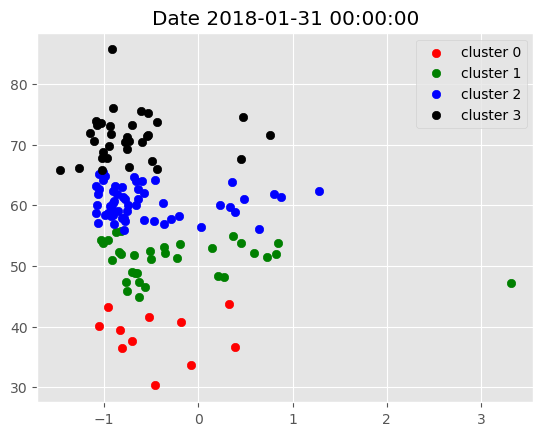

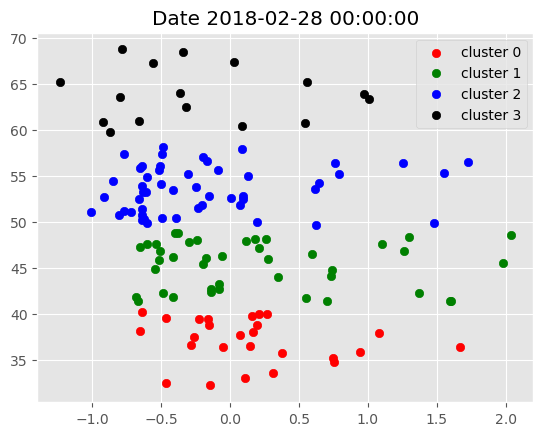

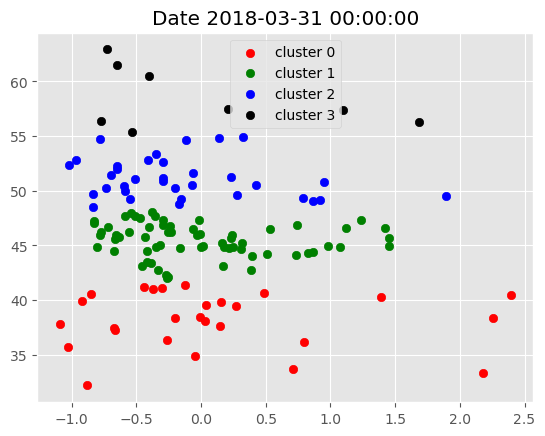

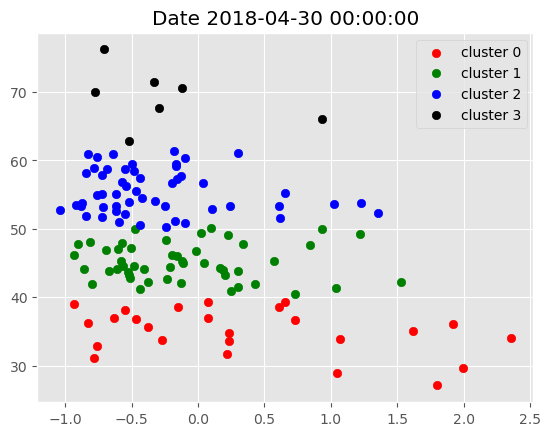

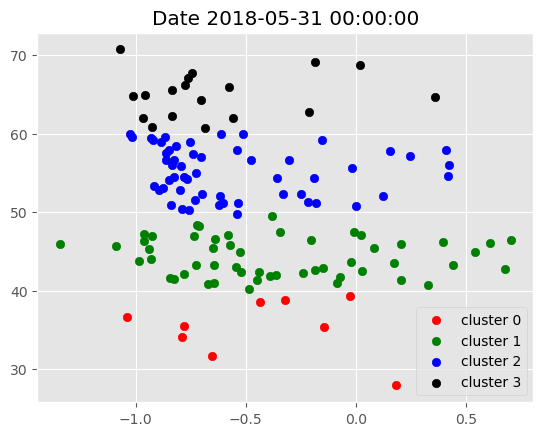

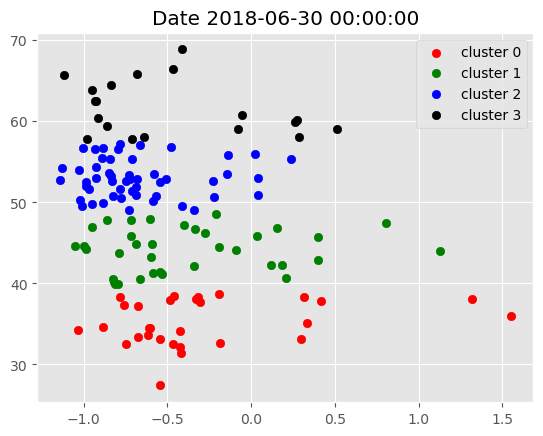

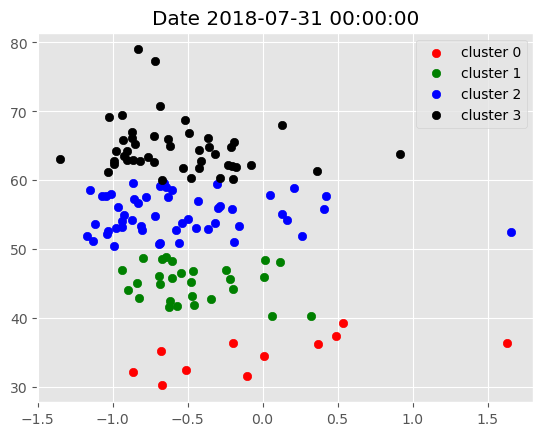

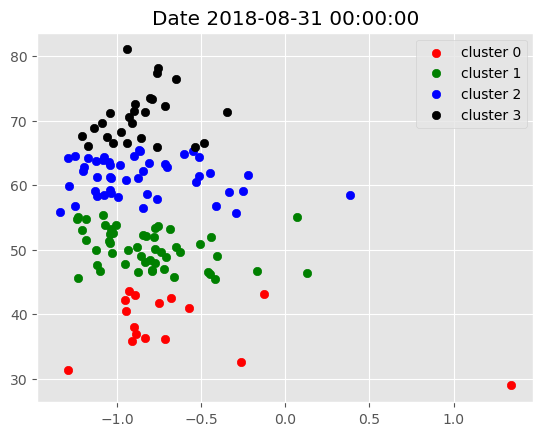

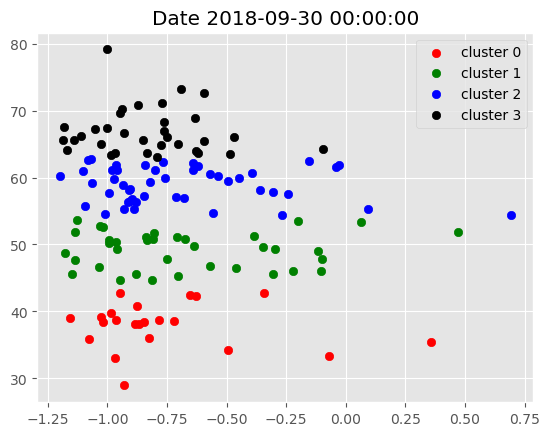

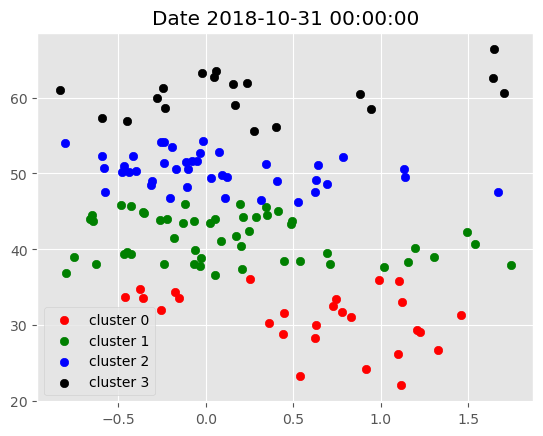

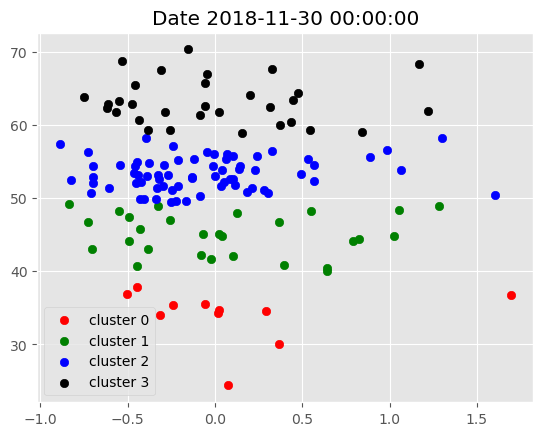

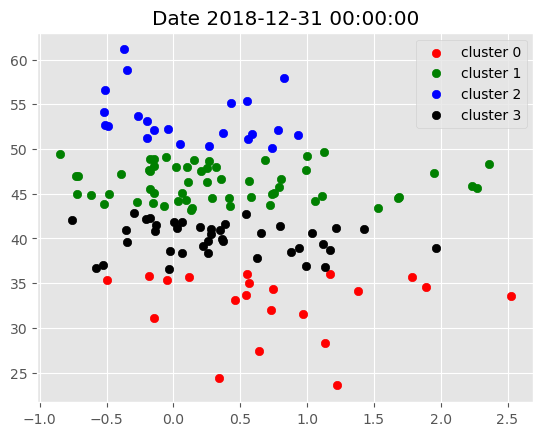

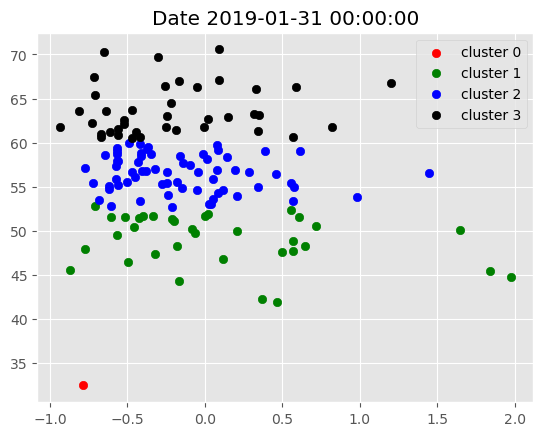

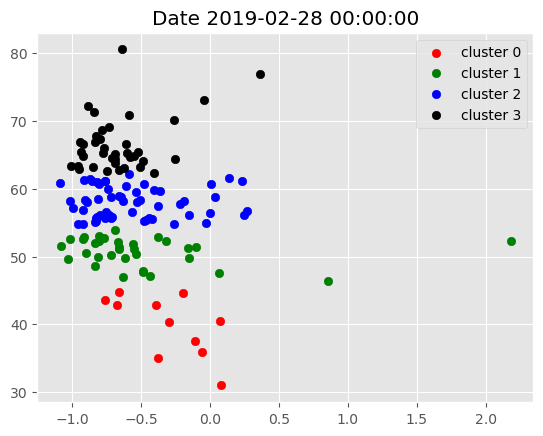

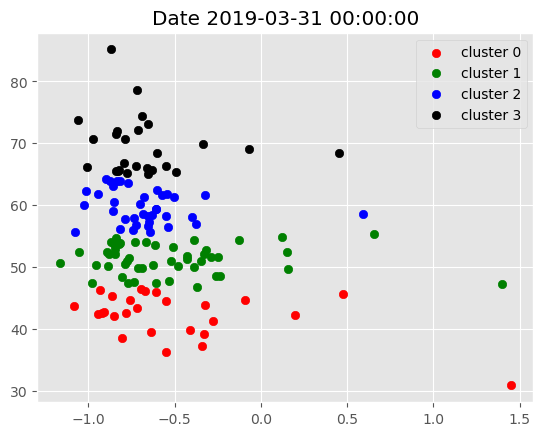

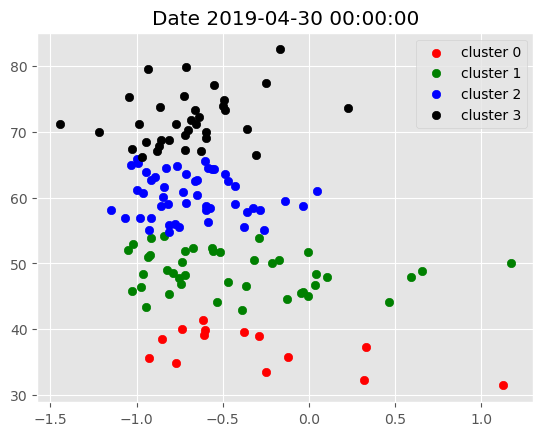

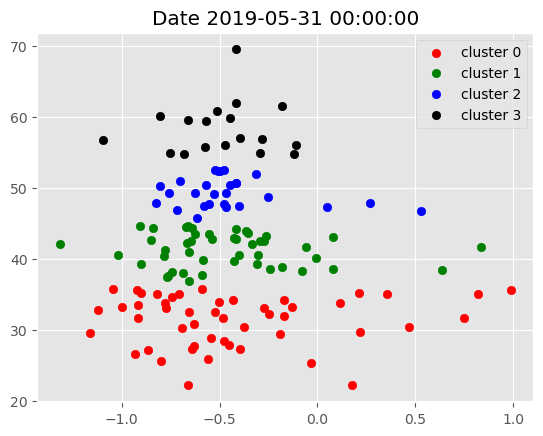

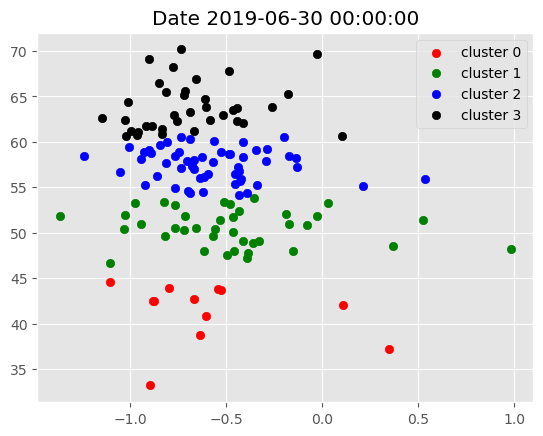

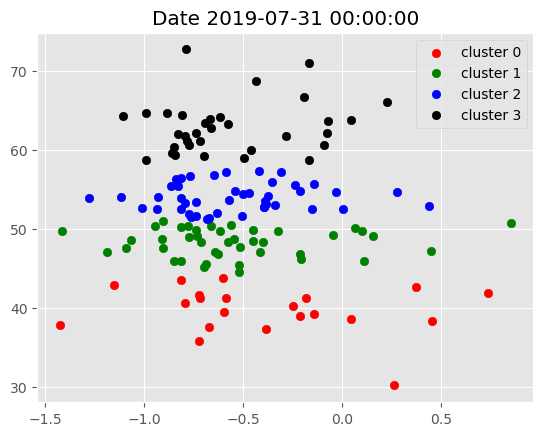

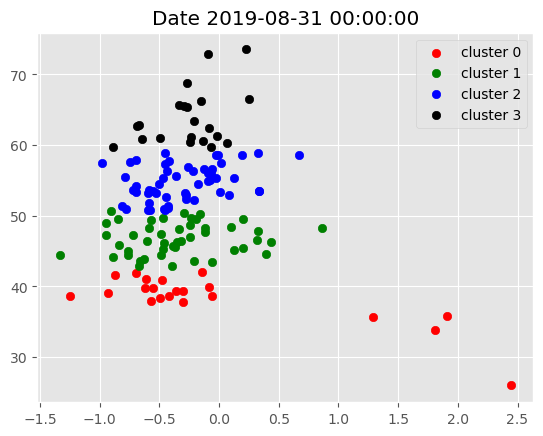

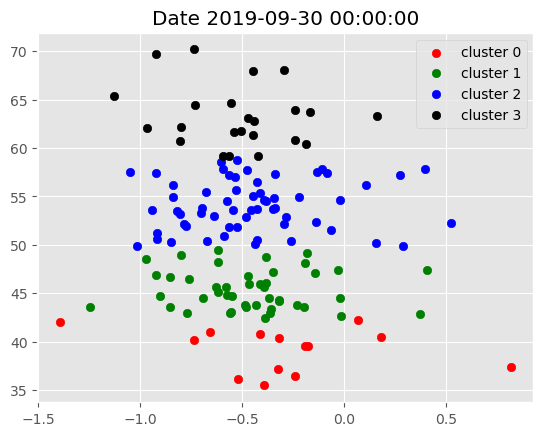

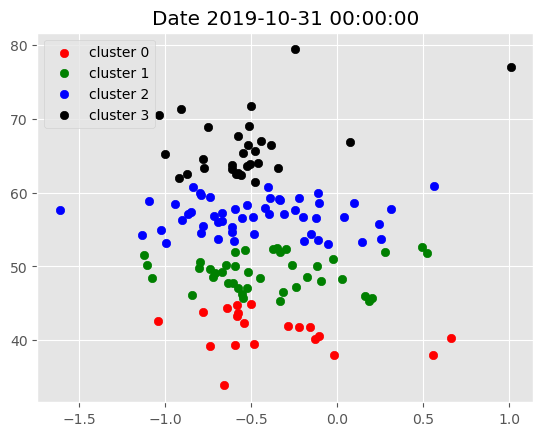

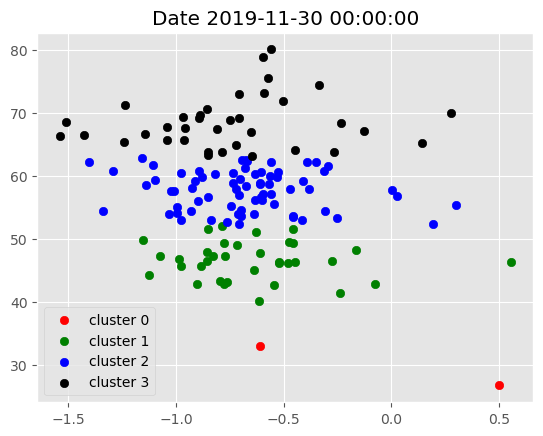

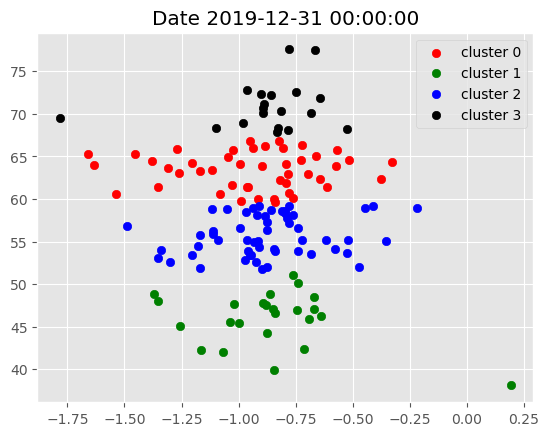

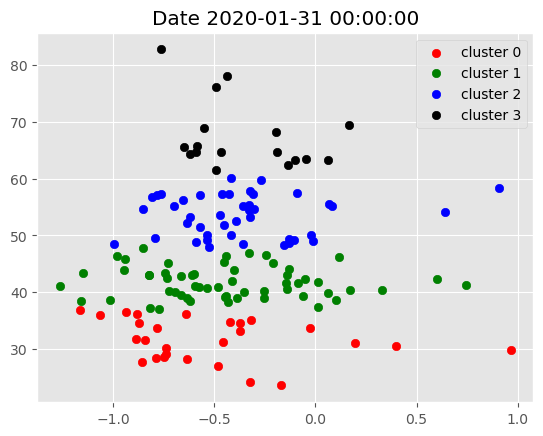

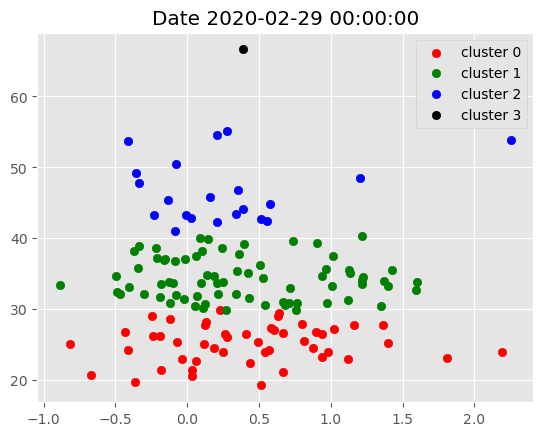

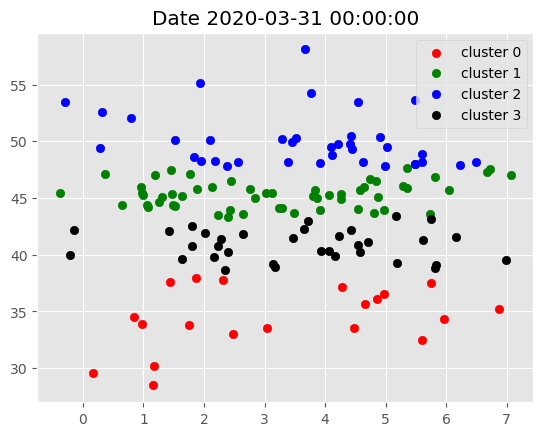

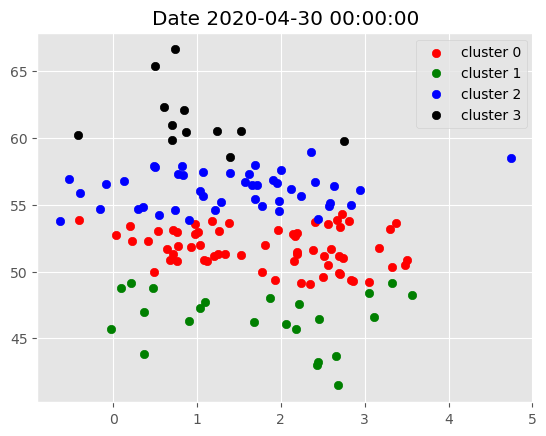

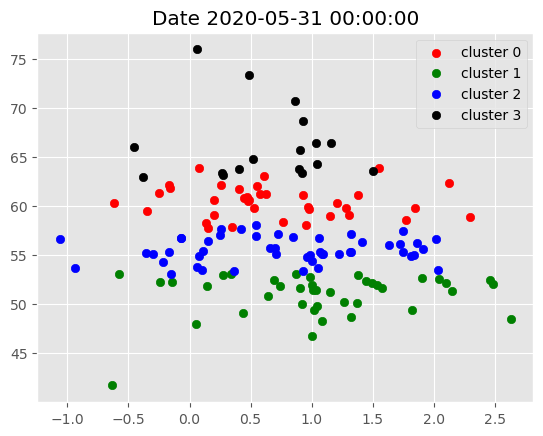

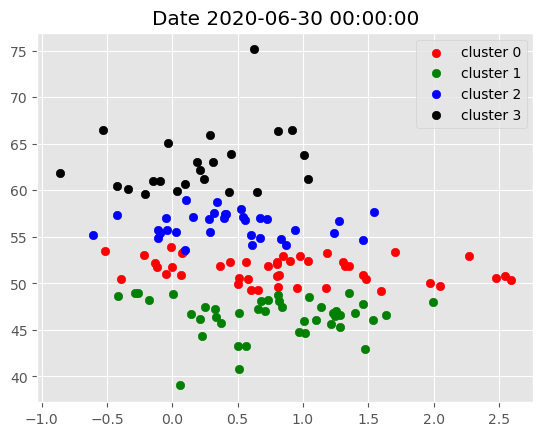

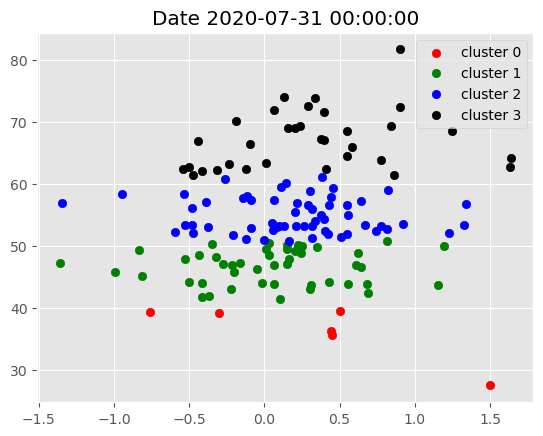

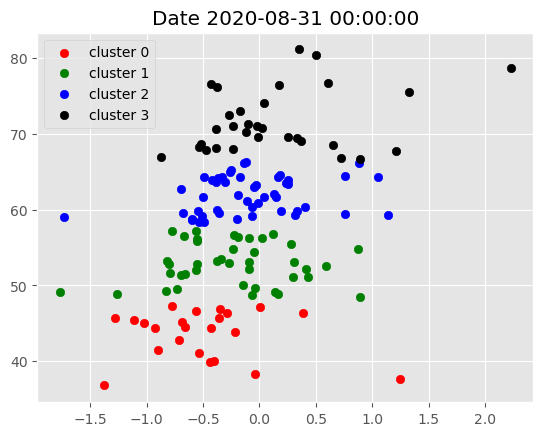

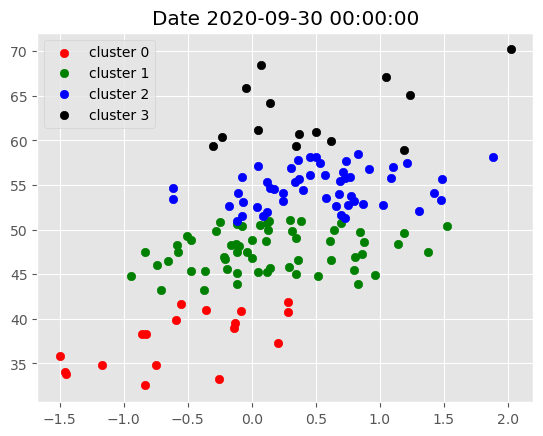

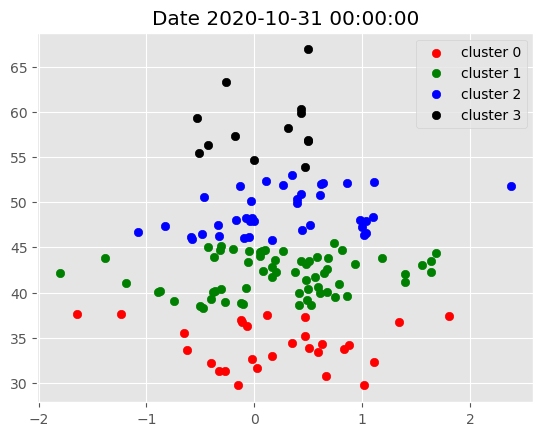

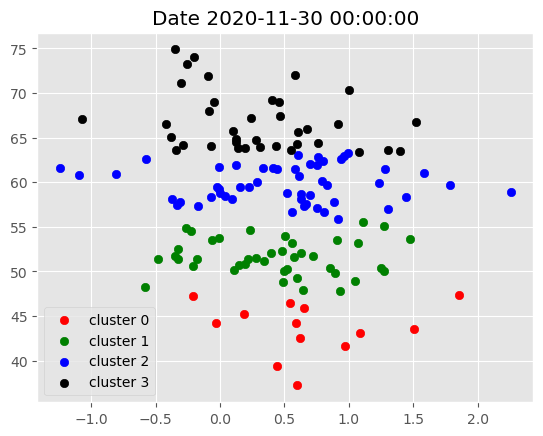

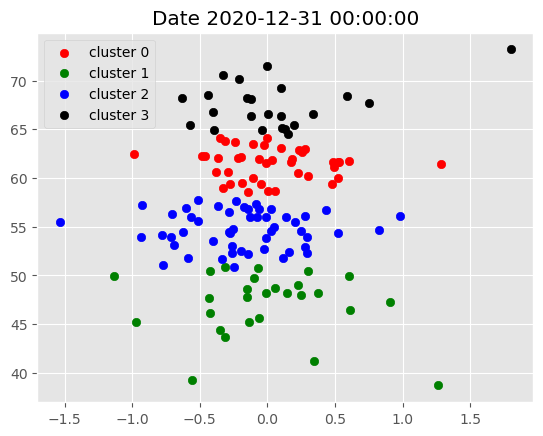

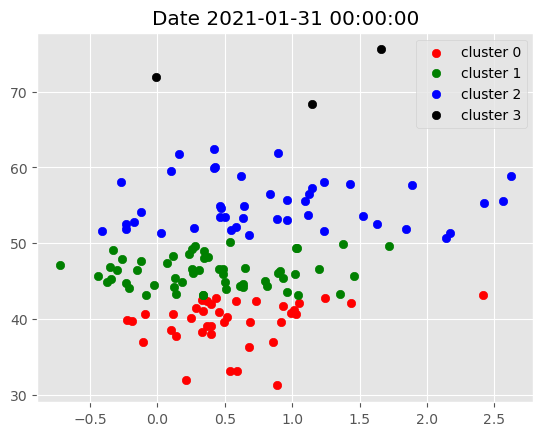

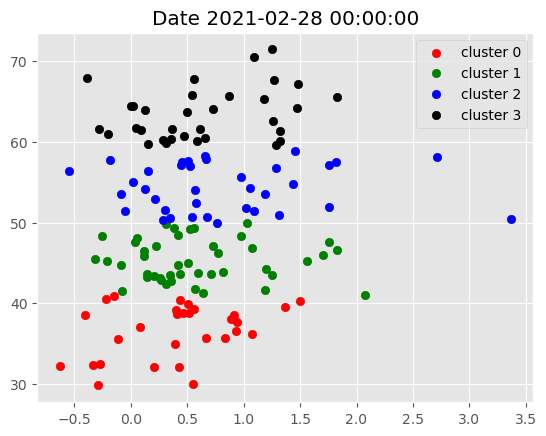

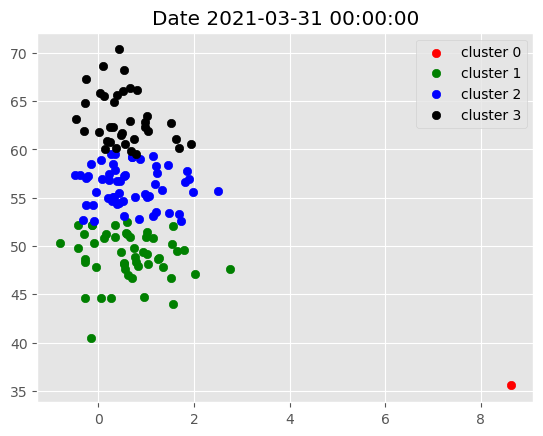

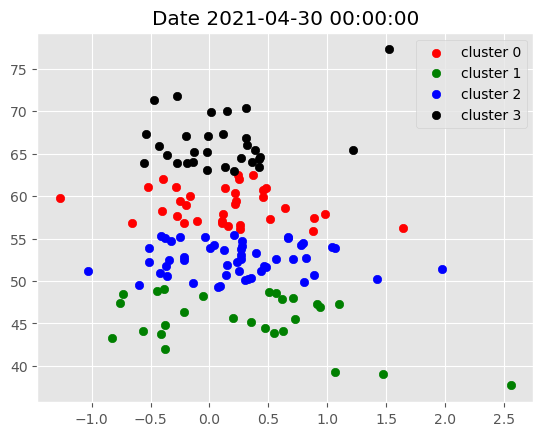

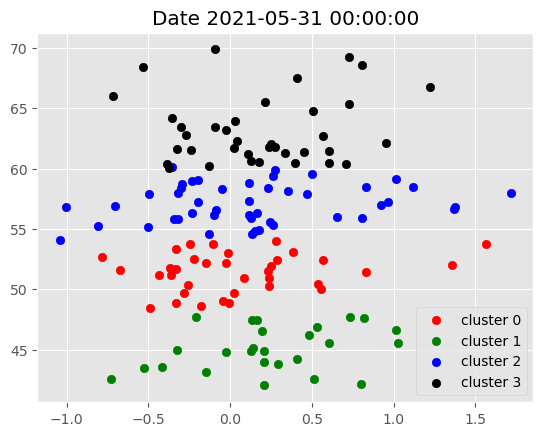

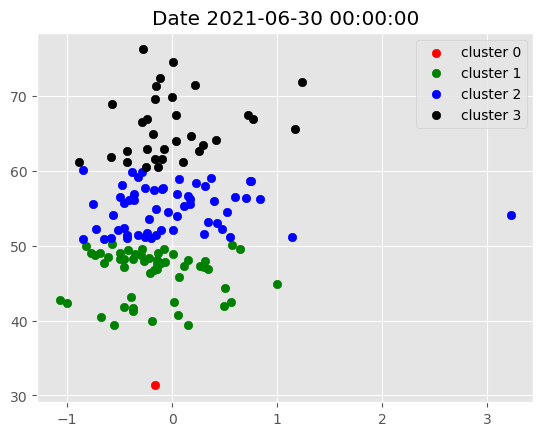

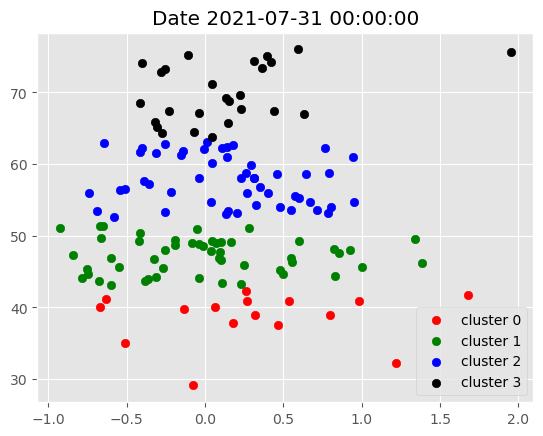

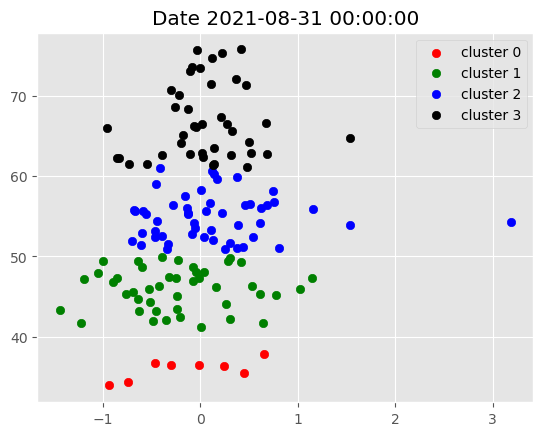

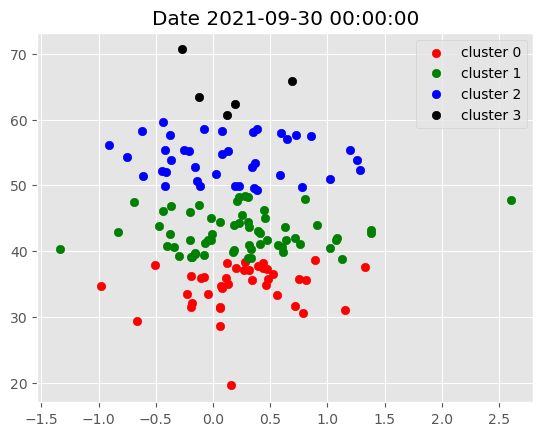

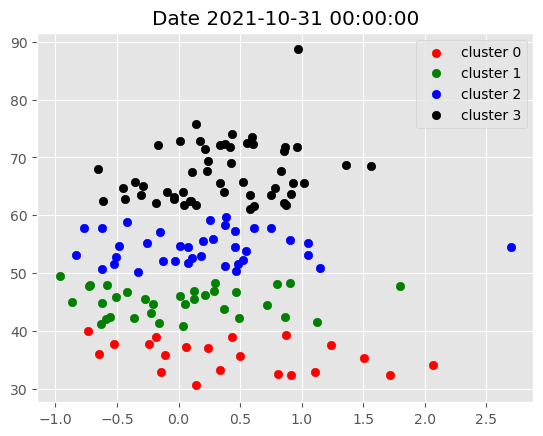

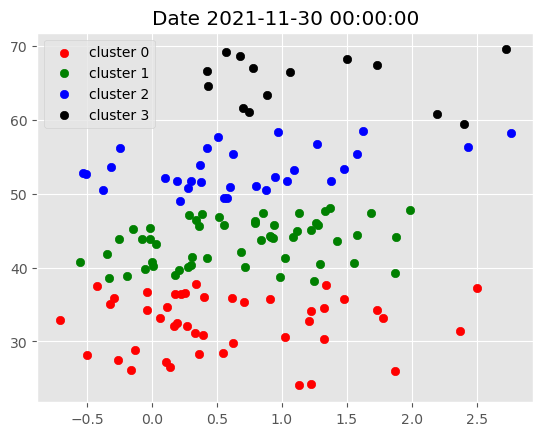

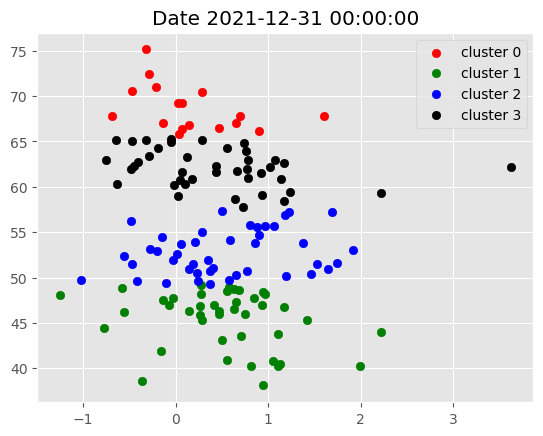

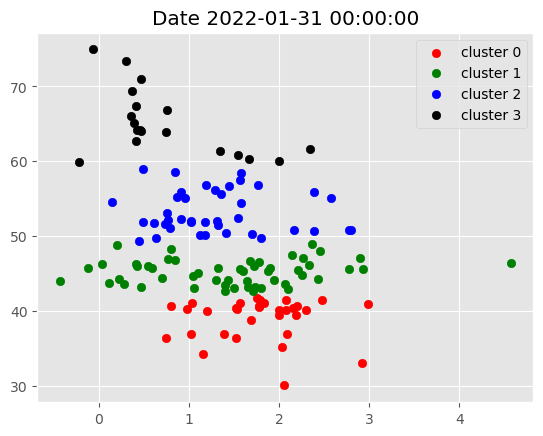

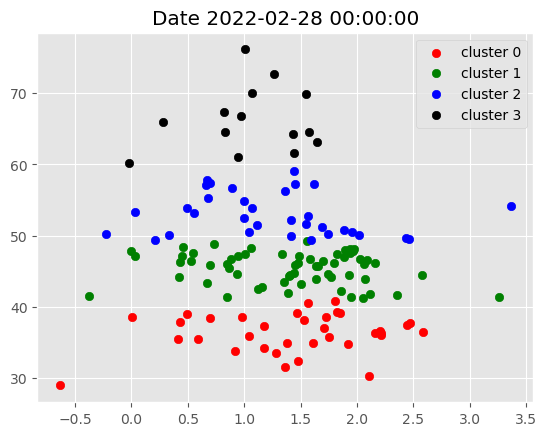

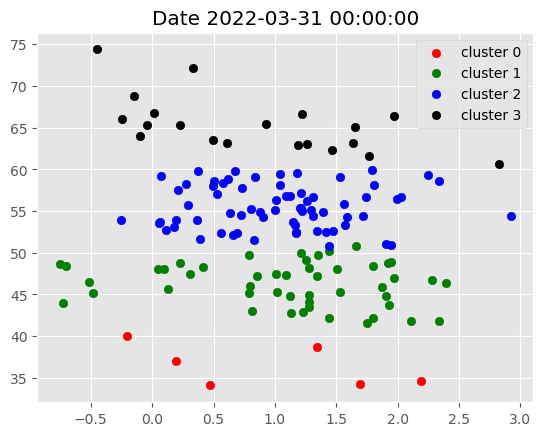

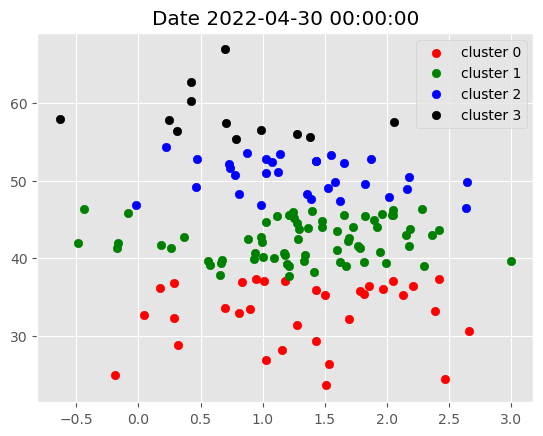

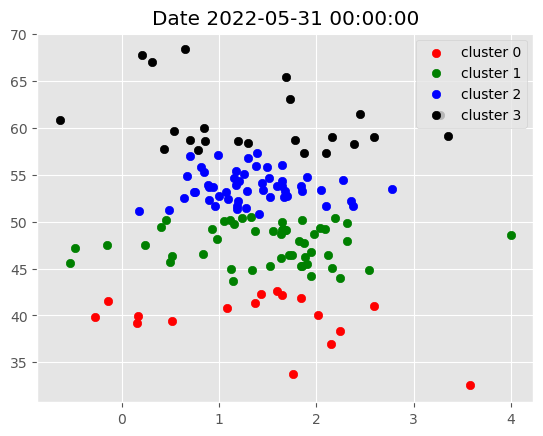

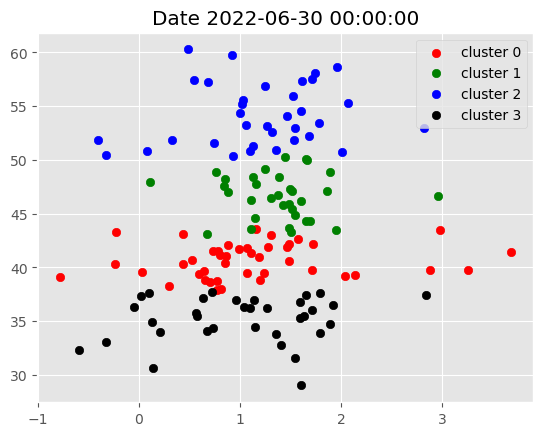

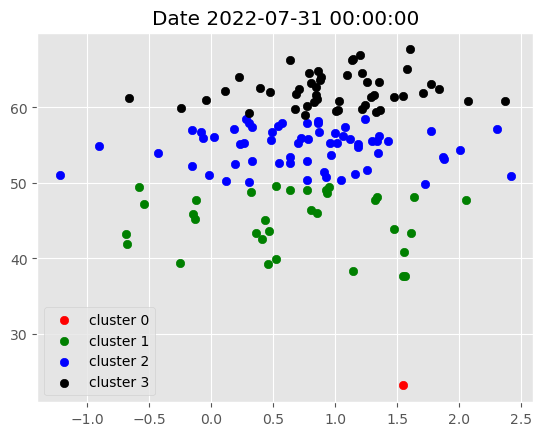

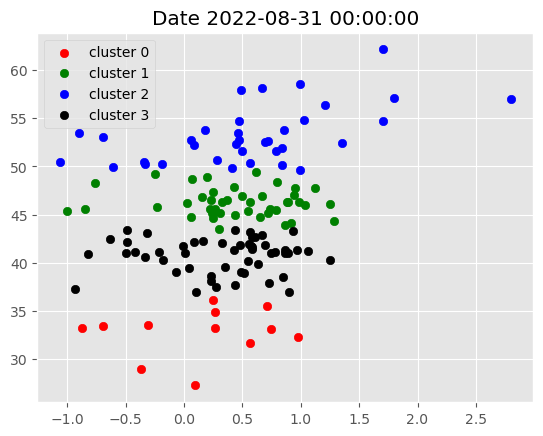

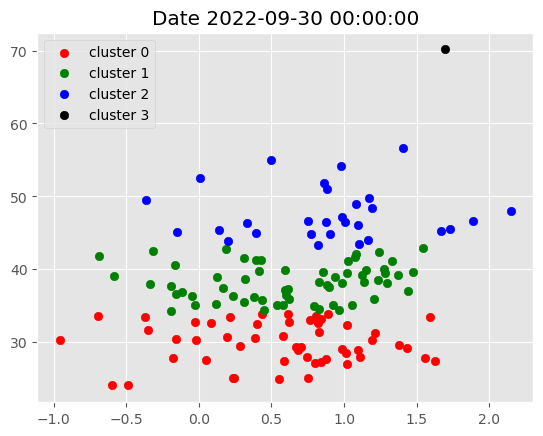

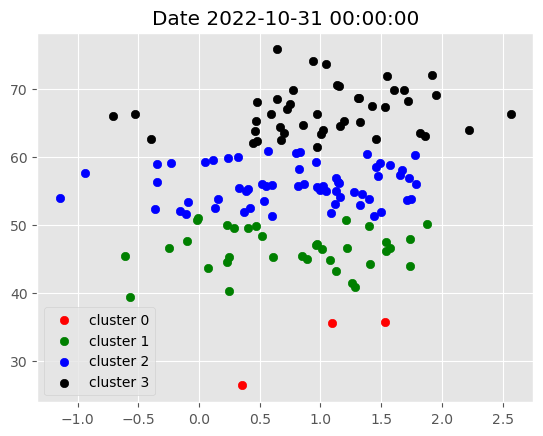

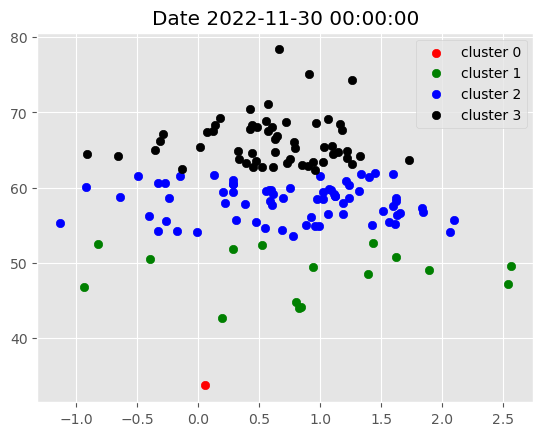

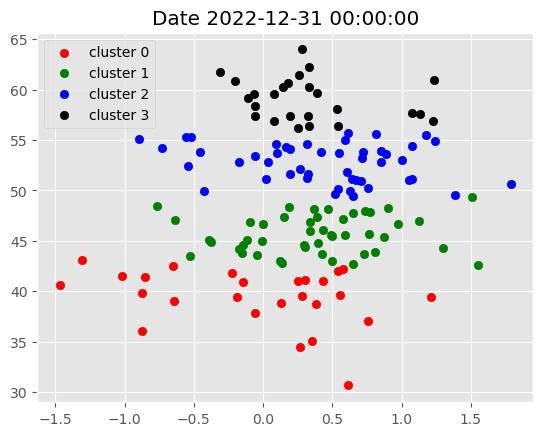

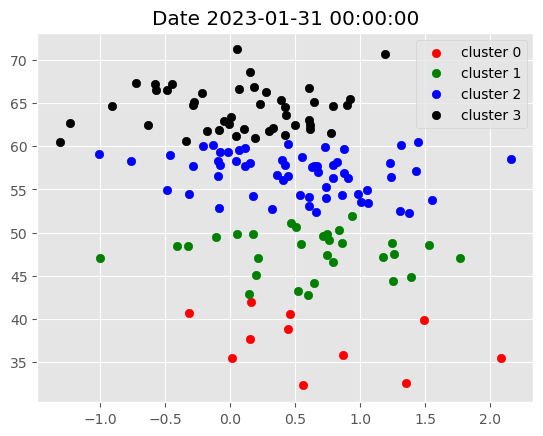

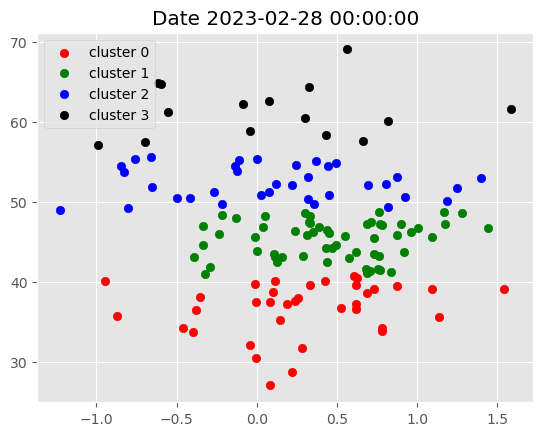

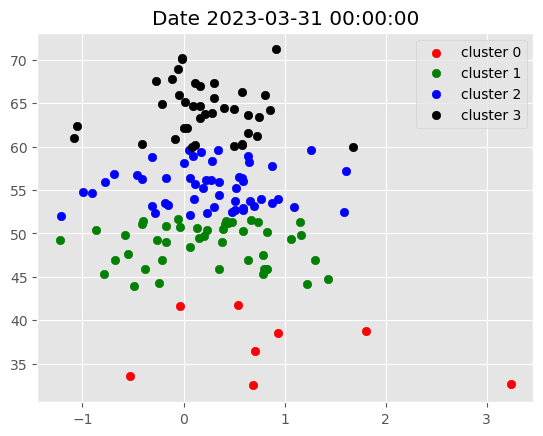

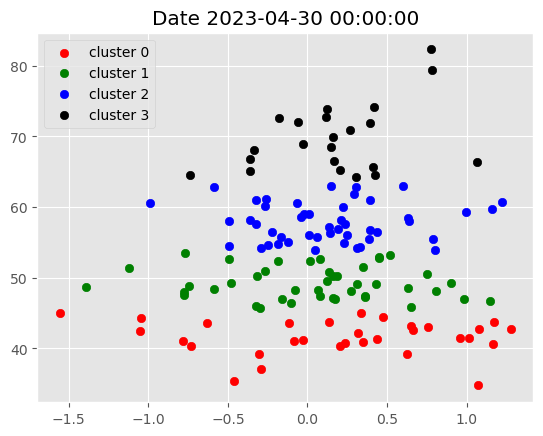

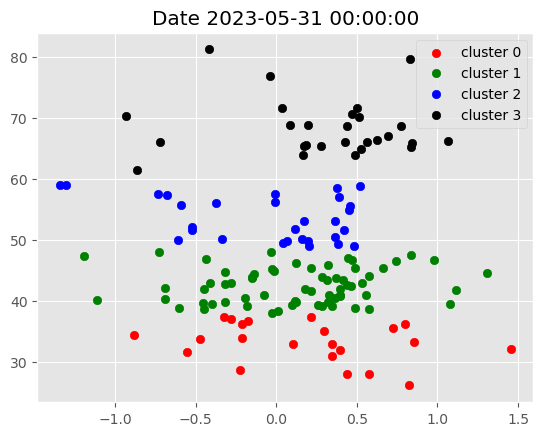

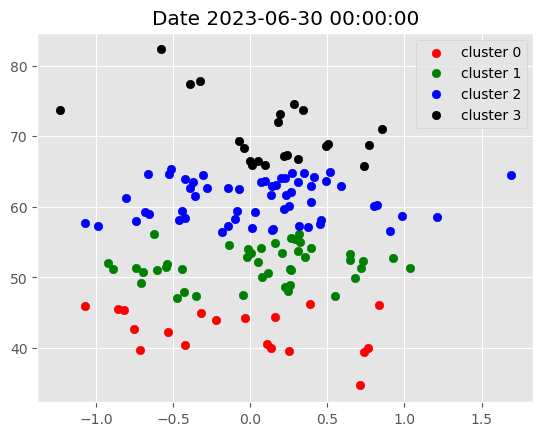

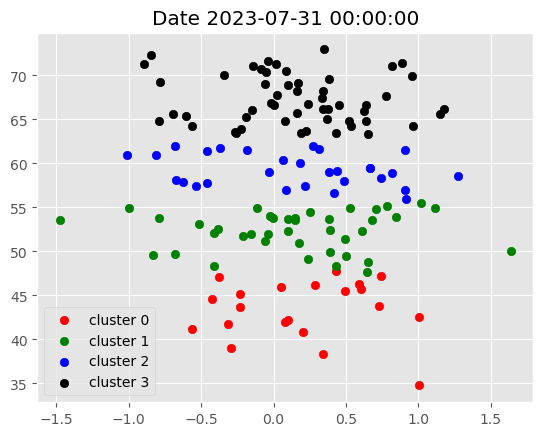

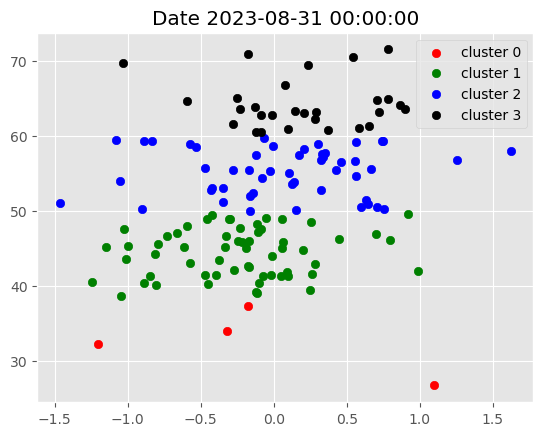

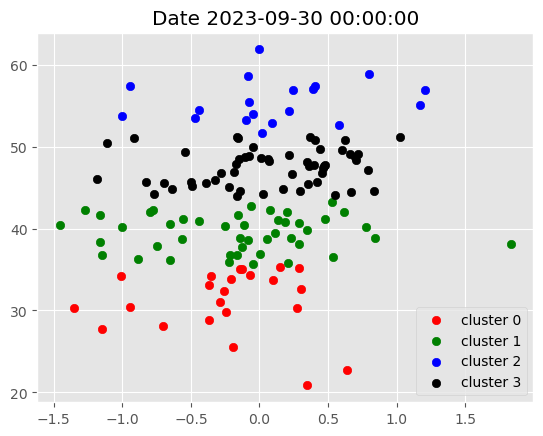

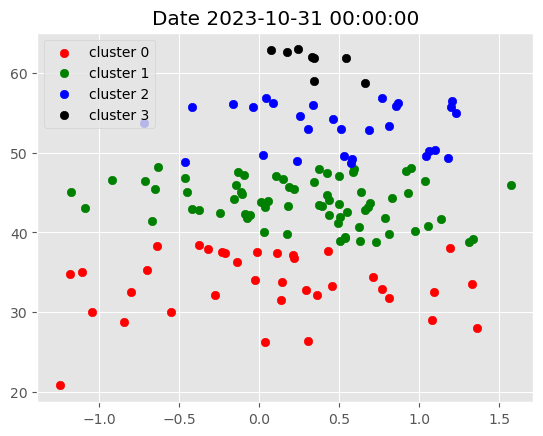

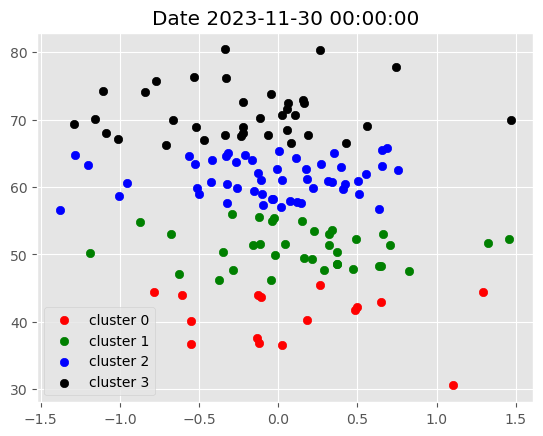

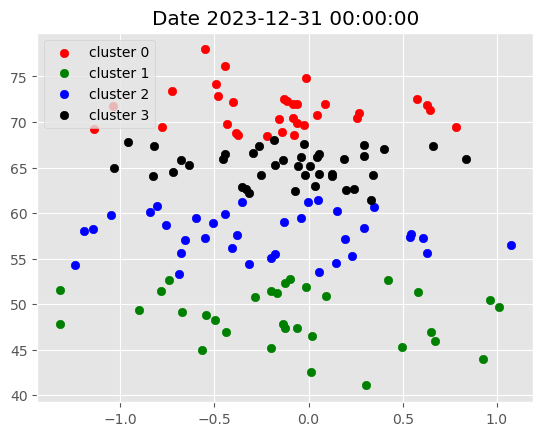

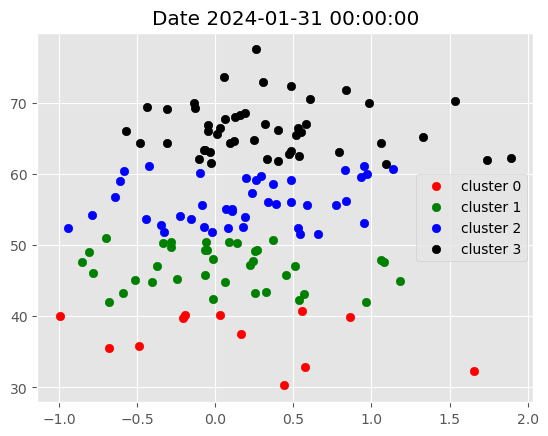

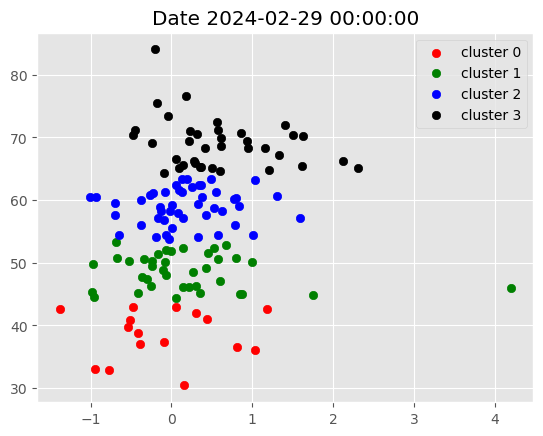

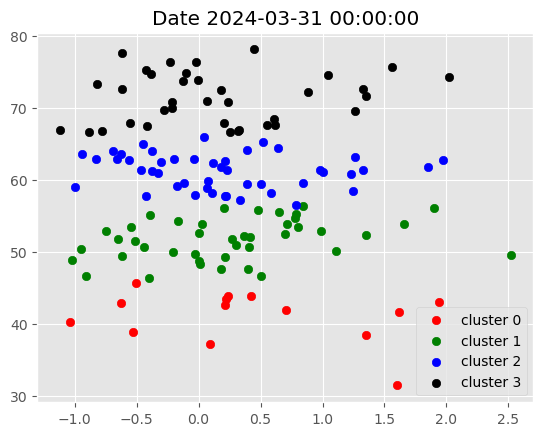

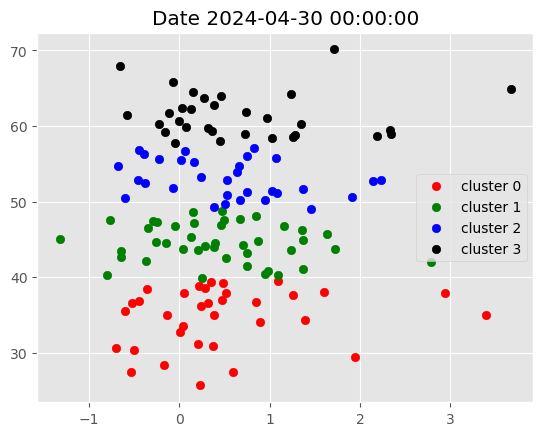

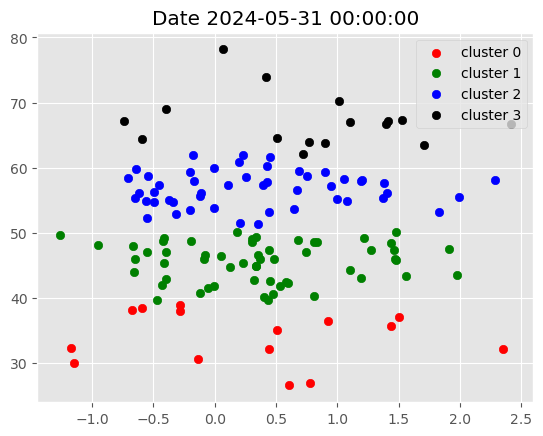

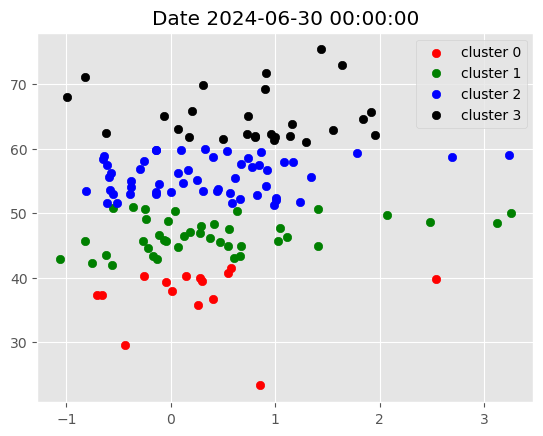

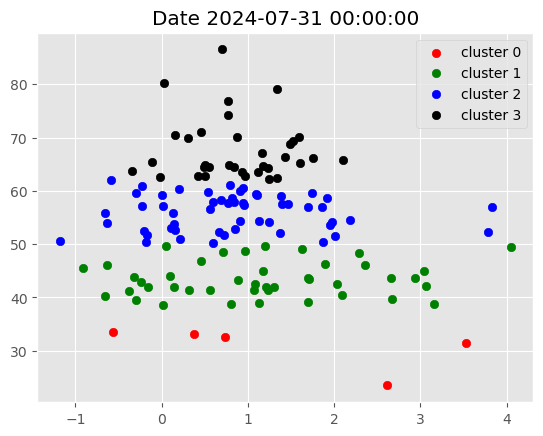

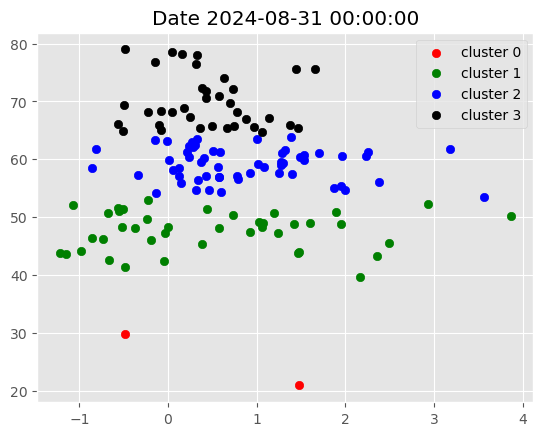

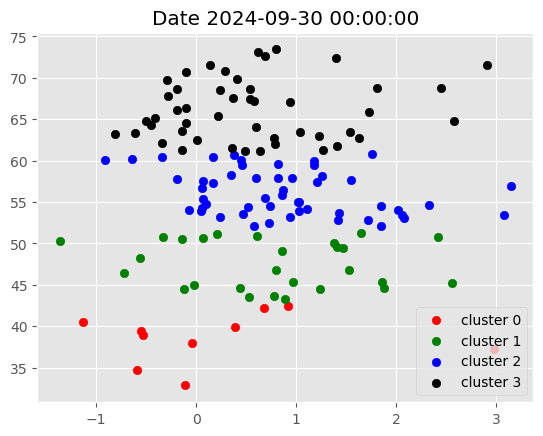

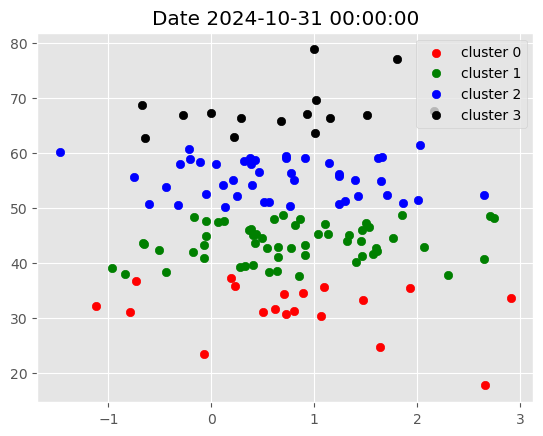

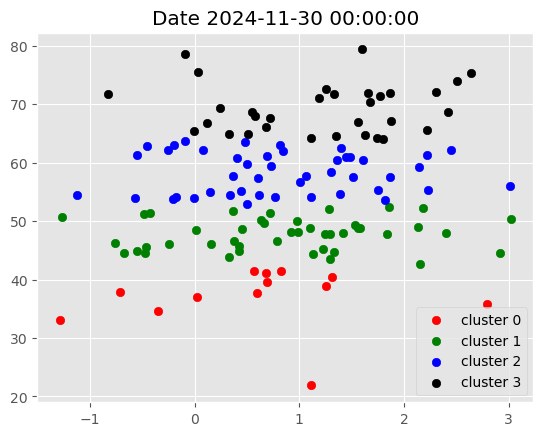

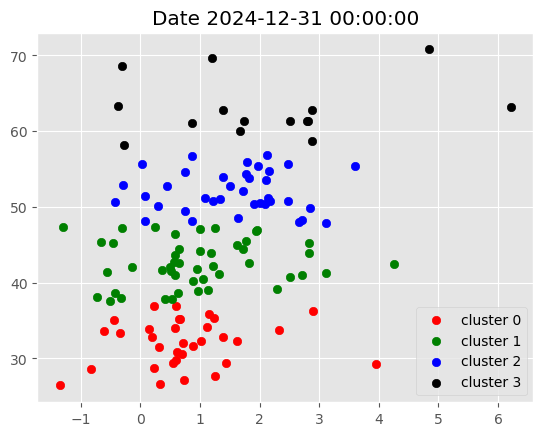

In [111]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level = 0)
    plt.title(f'Date {i}')
    plot_clusters(g)

We can note that the clusters are consistent with the pre-defined centroid range 

### 7. For each month, select assets based on the cluster and form a portfolio based on Efficient Frotier Max Sharpe ratio optimization

- Filter stocks corresponding to the cluster based on our hypothesis.
- This gives us the stocks in cluster 3, i.e., with RSI around 70. Our hypothesis is that these stocks will continue to outperform the market in the following month.

In [122]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()

fixed_dates

{'2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NOC',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NOC',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT', 'COP', 'INTC', 'MPC', 'NEE', 'PANW', 'STZ', 'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PARA',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX',
  'VZ'],
 '2

#### Define portfolio optimization function

- A function is defined which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the Sharpe ratio.
- With this, each stock in the given month will be given some weight in the portfolio.
- For this, a minimum of 1 year prices need to be supplied to the function.


In [143]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices = prices,
                                                     frequency = 252)

    cov = risk_models.sample_cov(prices = prices,
                                frequency = 252) # frequency = 252 is default as the number of trading days in a year

    ef = EfficientFrontier(expected_returns = returns,
                          cov_matrix = cov,
                          weight_bounds=(lower_bound, 0.1),
                          solver = 'SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()
    

- The weight bound specifies the range of weightage of a stock in the desired portfolio. (0,0.1) indicates that a stock can have a maximum contribution of 10% to the portfolio and a miniumum of 0%. This helps in diversifying the portfolio.

- Download fresh daily prices data only for shortlisted stocks

In [205]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers = stocks,
                    start = data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                    end = data.index.get_level_values('date').unique()[-1],auto_adjust=False, actions=False )

new_df

[*********************100%***********************]  159 of 159 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2017-01-31   28.095907   43.780571   36.375004  100.605431  113.379997   
2017-02-01   29.809210   43.622955   36.862671  100.022346  113.360001   
2017-02-02   29.758274   43.622955   37.228420  100.402252  113.160004   
2017-02-03   29.885614   43.465347   37.254543  101.153221  115.169998   
2017-02-06   30.165762   43.451012   36.949764  100.879333  114.459999   
...                ...         ...         ...         ...         ...   
2024-12-23  255.270004  178.389999  114.309998  358.769989  446.739990   
2024-12-24  258.200012  180.000000  114.760002  361.630005  447.940002   
2024-12-26  259.019989  179.199997  115.269997  360.429993  450.160004   
2024-12-27  255.589996  178.009995  114.989998  356.179993  446.480011   
2024-12-30  252.199997  176.199997  112.800003  352.489990  445.799988   

Price                                                                  ...  \
Ticker             ADI         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-01-31   64.266197   85.281319   81.339996  52.241634   31.376682  ...   
2017-02-01   65.321007   80.434174   81.279999  52.249748   32.091244  ...   
2017-02-02   64.514900   81.337746   82.760002  52.127819   32.008793  ...   
2017-02-03   64.763573   81.802193   84.410004  52.794464   32.347767  ...   
2017-02-06   64.772148   81.464386   82.820000  52.761940   32.228664  ...   
...                ...         ...         ...        ...         ...  ...   
2024-12-23  214.889999  294.149994  297.489990  72.470001  167.460007  ...   
2024-12-24  218.089996  296.459991  301.230011  72.839996  168.369995  ...   
2024-12-26  218.059998  297.230011  300.279999  73.339996  167.550003  ...   
2024-12-27  216.990005  296.179993  297.589996  73.000000  166.830002  ...   
2024-12-30  212.559998  292.970001  297.529999  72.550003  163.639999  ...   

Price         Volume                                                           \
Ticker           VLO     VRTX        VZ       WBA     WDAY      WDC       WFC   
Date                                                                            
2017-01-31  11657700  2418400  16844200   3424400  1260600  3617800  22409100   
2017-02-01   5204500  1754700  26004100   5080000  1462600  3897800  21157700   
2017-02-02   6193200  1290800  17787200   3667400  1555600  2982700  13044400   
2017-02-03   4416400  1226800  15166400   3167700  1201200  2624900  19879800   
2017-02-06   4297800  1423800  16151400   3418400  1143700  2307400  13940200   
...              ...      ...       ...       ...      ...      ...       ...   
2024-12-23   2832600  2204300  21292300  18506100  3676000  4111200  11817000   
2024-12-24   1170100  1468600  11712200   8724500   850500  1512100   4442700   
2024-12-26   1884400  1191500  12946400  15705800  1243900  2146000   6964300   
2024-12-27   1697800  1373400  15168100  11621000  1602800  4161800   7219500   
2024-12-30   2890200  1454900  15656100  13964000  1755100  4410100   8443200   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-01-31  27962700  1827500  19128100  
2017-02-01  27150000  3025400  15111800  
2017-02-02  26996100  1698700  12200100  
2017-02-03  22875900  1888800  12746300  
2017-02-06  27291600  2828800   9938200  
...              ...      ...       ...  
2024-12-23  26205400  1312400  12285100  
2024-12-24   8992400   692800   7807000  
2024-12-26  10994000  1218900   9652400  
2024-12-27  11384400  1086700  11943900  
2024-12-30   9785100  2179500  11075400  

[1992 rows x 954 columns]

- Calculate daily returns for each stock which could land up in the portfolio.
- Loop over each month start, select the stocks for the month and calculate their weights for the next month
- If the maximum sharpe ratio optimization fails for a given month, apply equally weighted weights
- Calcaulate portfolio return for each day

In [233]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df =pd.DataFrame()

for start_date in fixed_dates.keys():
    try:

        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
        cols = fixed_dates[start_date]
    
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months = 12)).strftime('%Y-%m-%d')
    
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days = 1)).strftime('%Y-%m-%d')
    
        optimization_df = new_df['Adj Close'][optimization_start_date:optimization_end_date][cols]

        success = False
        
        try:
            weights = optimize_weights(prices = optimization_df,
                                   lower_bound= 0)
        
            weights = pd.DataFrame(weights, index = pd.Series(0))

            success = True
        except:
            print(f'Max-Sharpe Optimization failed for {start_date}. Continuing with Equal-Weights')

        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                             index = optimization_df.columns.tolist(),
                             columns = pd.Series(0)).T
        temp_df = returns_dataframe[start_date:end_date]
    
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                    .merge(weights.stack().to_frame('weight').reset_index(level=0, drop = True),
                        left_index= True,     
                        right_index = True)\
                    .reset_index().set_index(['Date','Ticker']).unstack().stack()
        
        temp_df.index.names = ['date','ticker']
    
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
    
        temp_df = temp_df.groupby(level = 0)['weighted_return'].sum().to_frame('Strategy Return')
    
        portfolio_df = pd.concat([portfolio_df,temp_df], axis = 0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max-Sharpe Optimization failed for 2018-04-01. Continuing with Equal-Weights
Max-Sharpe Optimization failed for 2018-05-01. Continuing with Equal-Weights
Max-Sharpe Optimization failed for 2020-03-01. Continuing with Equal-Weights
Max-Sharpe Optimization failed for 2020-04-01. Continuing with Equal-Weights
Max-Sharpe Optimization failed for 2021-02-01. Continuing with Equal-Weights
Max-Sharpe Optimization failed for 2021-10-01. Continuing with Equal-Weights
Max-Sharpe Optimization failed for 2022-10-01. Continuing with Equal-Weights
Max-Sharpe Optimization failed for 2023-11-01. Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-02-01,-0.009467
2018-02-02,-0.014569
2018-02-05,-0.039597
2018-02-06,0.017050
2018-02-07,0.006214
...,...
2024-12-23,-0.000334
2024-12-24,0.013387
2024-12-26,0.000488


- the Max Sharpe ratio weights fail to give us a weightage for our restricted criteria certain times, thus it has been replaced with equal weightage in cases wherever it was failing.

<Axes: xlabel='date'>

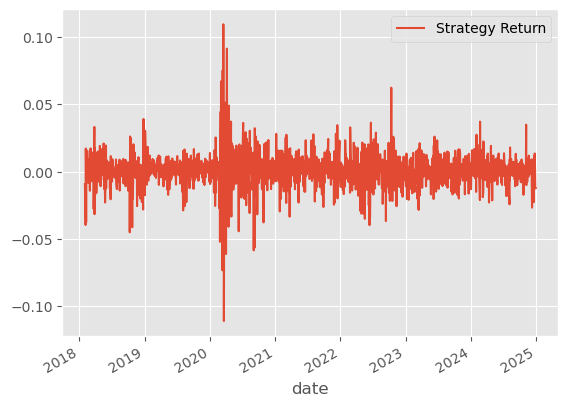

In [227]:
portfolio_df.plot()

- To make an equally distributed portfolio, lower bound will be set as follows-
  lower bound value = (1/(2*number of stocks in the portfolio)) [rounded off to 2 decimal places ]

- Interestingly, the above lower bound gives an optimization error. Perhaps the stock data does not fit the expected restrictions.

In [214]:
# weights = optimize_weights(prices = optimization_df,
#                            lower_bound= 0.001)

In [215]:
# weights = pd.DataFrame(weights, index = pd.Series(0))

- Calculating daily returns

In [217]:
# temp_df = returns_dataframe['2018-02-01':'2018-02-28']

In [218]:
# temp_df = (temp_df.stack().to_frame('return').reset_index(level=0)\
#         .merge(weights.stack().to_frame('weight').reset_index(level=0, drop = True),
#                 left_index= True,     
#                 right_index = True)\
#        .reset_index().set_index(['Date','Ticker']).unstack().stack())
    

### 8. Visualize portfolio returns and compare to S&P500 returns.

In [257]:
spy = yf.download(tickers ='SPY',
                 start = '2015-12-23',
                 end = dt.date.today(),
                 auto_adjust = False)
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'},axis = 1)
spy_ret.columns = spy_ret.columns.droplevel(level=1)

portfolio_df = portfolio_df.merge(spy_ret, left_index = True, right_index = True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-02-01,-0.009467,-0.001136
2018-02-02,-0.014569,-0.022010
2018-02-05,-0.039597,-0.042722
2018-02-06,0.017050,0.019511
2018-02-07,0.006214,-0.005440
...,...,...
2024-12-23,-0.000334,0.005970
2024-12-24,0.013387,0.011054
2024-12-26,0.000488,0.000067
2024-12-27,-0.011789,-0.010582


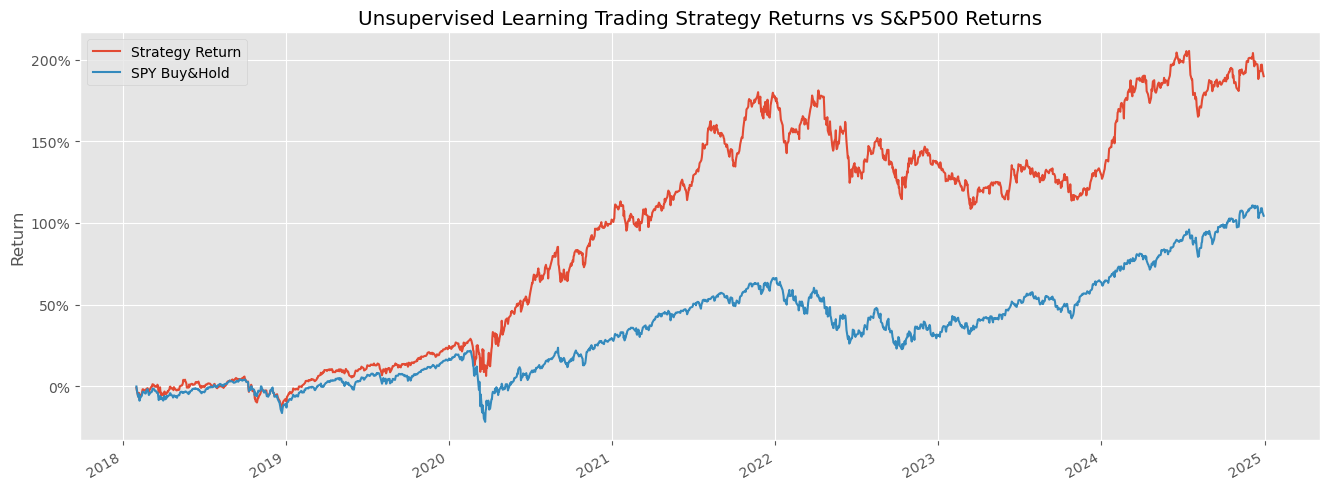

In [265]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-12-30'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns vs S&P500 Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()